## Import datasets

In [1]:
import torch
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from model import *
from utils import *

## Data transformation

In [4]:
class CIFAR10_ds(datasets.CIFAR10):
    def __init__(self, root=".", train=True, download=True, transform= None):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
 

In [15]:
train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, 
                         min_width=16, fill_value=(0.4914, 0.4822 ,0.4465), mask_fill_value = None),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]
)

In [16]:
test_transforms = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2()
])

In [17]:
train_data = CIFAR10_ds(root=".", train=True, download=True, transform=train_transforms)
test_data = CIFAR10_ds(root=".", train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_data

Dataset CIFAR10_ds
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose([
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
             HorizontalFlip(always_apply=False, p=0.5),
             RGBShift(always_apply=False, p=0.5, r_shift_limit=(-15, 15), g_shift_limit=(-15, 15), b_shift_limit=(-15, 15)),
             RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
             Normalize(always_apply=False, p=1.0, me

In [19]:
batch_size = 128

kwargs = dict(shuffle=True, batch_size=batch_size) 

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [20]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


## Sample image with augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 32, 32])


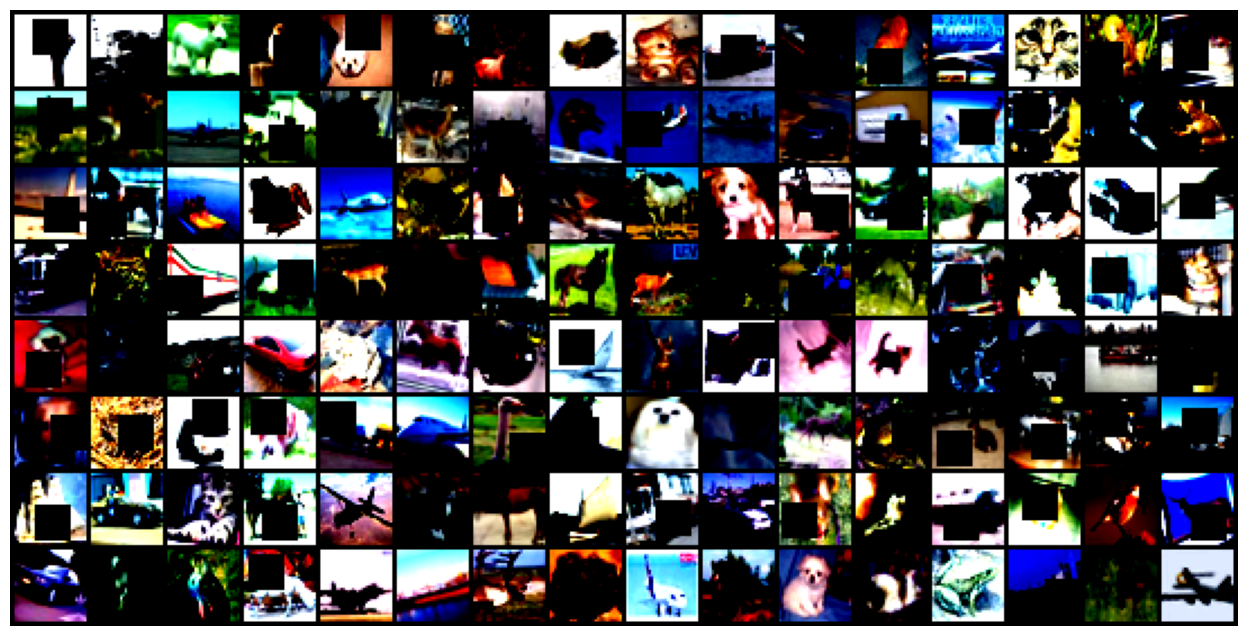

In [21]:
for images, label in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [22]:
get_summary(Net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             160
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 32, 15, 15]           4,640
      BatchNorm2d-10           [-1, 32, 15, 15]              64
             ReLU-11           [-1, 32, 15, 15]               0
          Dropout-12           [-1, 32, 15, 15]               0
    ResidualBlock-13           [-1, 32, 15, 15]               0
           Conv2d-14           [-1, 24,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training the data and calculating validation results

In [23]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [24]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# New Line
train_criterion = nn.CrossEntropyLoss() #Loss function
test_criterion = nn.CrossEntropyLoss() #Loss function
num_epochs = 50

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, train_criterion)
    print(train_acc_val)
    test_acc_val, test_loss = test(model, device, test_loader, test_criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=1.6442 Batch_id=390 Accuracy=35.00: 100%|█| 391/391 [01:01<00:00,  6


34.998
Test set: Average loss: 1.3218, Accuracy: 5141/10000 (51.41%)

Epoch 1: SGD lr 0.0500 -> 0.0400
Epoch 2


Train: Loss=1.3117 Batch_id=390 Accuracy=48.94: 100%|█| 391/391 [01:04<00:00,  6


48.94
Test set: Average loss: 1.1461, Accuracy: 5862/10000 (58.62%)

Epoch 2: SGD lr 0.0400 -> 0.0320
Epoch 3


Train: Loss=1.1037 Batch_id=390 Accuracy=53.61: 100%|█| 391/391 [01:03<00:00,  6


53.61
Test set: Average loss: 1.0085, Accuracy: 6462/10000 (64.62%)

Epoch 3: SGD lr 0.0320 -> 0.0256
Epoch 4


Train: Loss=1.0260 Batch_id=390 Accuracy=57.11: 100%|█| 391/391 [01:06<00:00,  5


57.108
Test set: Average loss: 0.9245, Accuracy: 6680/10000 (66.80%)

Epoch 4: SGD lr 0.0256 -> 0.0205
Epoch 5


Train: Loss=1.2166 Batch_id=390 Accuracy=59.40: 100%|█| 391/391 [01:04<00:00,  6


59.396
Test set: Average loss: 0.8446, Accuracy: 7062/10000 (70.62%)

Epoch 5: SGD lr 0.0205 -> 0.0164
Epoch 6


Train: Loss=0.9454 Batch_id=390 Accuracy=61.58: 100%|█| 391/391 [01:05<00:00,  6


61.584
Test set: Average loss: 0.7888, Accuracy: 7224/10000 (72.24%)

Epoch 6: SGD lr 0.0164 -> 0.0131
Epoch 7


Train: Loss=0.8054 Batch_id=390 Accuracy=62.67: 100%|█| 391/391 [01:10<00:00,  5


62.666
Test set: Average loss: 0.7822, Accuracy: 7271/10000 (72.71%)

Epoch 7: SGD lr 0.0131 -> 0.0105
Epoch 8


Train: Loss=1.0682 Batch_id=390 Accuracy=63.77: 100%|█| 391/391 [01:22<00:00,  4


63.77
Test set: Average loss: 0.7558, Accuracy: 7323/10000 (73.23%)

Epoch 8: SGD lr 0.0105 -> 0.0084
Epoch 9


Train: Loss=0.7984 Batch_id=390 Accuracy=64.26: 100%|█| 391/391 [01:19<00:00,  4


64.26
Test set: Average loss: 0.7438, Accuracy: 7350/10000 (73.50%)

Epoch 9: SGD lr 0.0084 -> 0.0067
Epoch 10


Train: Loss=0.9516 Batch_id=390 Accuracy=64.93: 100%|█| 391/391 [01:18<00:00,  4


64.928
Test set: Average loss: 0.6985, Accuracy: 7537/10000 (75.37%)

Epoch 10: SGD lr 0.0067 -> 0.0054
Epoch 11


Train: Loss=1.1603 Batch_id=390 Accuracy=65.43: 100%|█| 391/391 [01:17<00:00,  5


65.428
Test set: Average loss: 0.7164, Accuracy: 7484/10000 (74.84%)

Epoch 11: SGD lr 0.0054 -> 0.0043
Epoch 12


Train: Loss=0.7680 Batch_id=390 Accuracy=65.86: 100%|█| 391/391 [01:17<00:00,  5


65.862
Test set: Average loss: 0.6925, Accuracy: 7584/10000 (75.84%)

Epoch 12: SGD lr 0.0043 -> 0.0034
Epoch 13


Train: Loss=0.9042 Batch_id=390 Accuracy=66.31: 100%|█| 391/391 [01:18<00:00,  5


66.314
Test set: Average loss: 0.6856, Accuracy: 7580/10000 (75.80%)

Epoch 13: SGD lr 0.0034 -> 0.0027
Epoch 14


Train: Loss=1.0478 Batch_id=390 Accuracy=66.46: 100%|█| 391/391 [01:39<00:00,  3


66.458
Test set: Average loss: 0.6843, Accuracy: 7593/10000 (75.93%)

Epoch 14: SGD lr 0.0027 -> 0.0022
Epoch 15


Train: Loss=0.7709 Batch_id=390 Accuracy=66.91: 100%|█| 391/391 [03:22<00:00,  1


66.914
Test set: Average loss: 0.6836, Accuracy: 7599/10000 (75.99%)

Epoch 15: SGD lr 0.0022 -> 0.0018
Epoch 16


Train: Loss=0.7674 Batch_id=390 Accuracy=67.04: 100%|█| 391/391 [03:30<00:00,  1


67.044
Test set: Average loss: 0.6756, Accuracy: 7641/10000 (76.41%)

Epoch 16: SGD lr 0.0018 -> 0.0014
Epoch 17


Train: Loss=0.8809 Batch_id=390 Accuracy=67.22: 100%|█| 391/391 [03:11<00:00,  2


67.222
Test set: Average loss: 0.6679, Accuracy: 7677/10000 (76.77%)

Epoch 17: SGD lr 0.0014 -> 0.0011
Epoch 18


Train: Loss=0.9639 Batch_id=390 Accuracy=67.07: 100%|█| 391/391 [03:13<00:00,  2


67.07
Test set: Average loss: 0.6779, Accuracy: 7627/10000 (76.27%)

Epoch 18: SGD lr 0.0011 -> 0.0009
Epoch 19


Train: Loss=1.1284 Batch_id=390 Accuracy=67.25: 100%|█| 391/391 [03:13<00:00,  2


67.248
Test set: Average loss: 0.6685, Accuracy: 7671/10000 (76.71%)

Epoch 19: SGD lr 0.0009 -> 0.0007
Epoch 20


Train: Loss=0.8713 Batch_id=390 Accuracy=67.40: 100%|█| 391/391 [03:05<00:00,  2


67.404
Test set: Average loss: 0.6671, Accuracy: 7706/10000 (77.06%)

Epoch 20: SGD lr 0.0007 -> 0.0006
Epoch 21


Train: Loss=0.9688 Batch_id=390 Accuracy=67.63: 100%|█| 391/391 [03:17<00:00,  1


67.628
Test set: Average loss: 0.6718, Accuracy: 7662/10000 (76.62%)

Epoch 21: SGD lr 0.0006 -> 0.0005
Epoch 22


Train: Loss=0.8010 Batch_id=390 Accuracy=67.44: 100%|█| 391/391 [03:00<00:00,  2


67.438
Test set: Average loss: 0.6638, Accuracy: 7697/10000 (76.97%)

Epoch 22: SGD lr 0.0005 -> 0.0004
Epoch 23


Train: Loss=0.9916 Batch_id=390 Accuracy=67.32: 100%|█| 391/391 [02:55<00:00,  2


67.316
Test set: Average loss: 0.6689, Accuracy: 7678/10000 (76.78%)

Epoch 23: SGD lr 0.0004 -> 0.0003
Epoch 24


Train: Loss=1.0685 Batch_id=390 Accuracy=67.99: 100%|█| 391/391 [02:55<00:00,  2


67.986
Test set: Average loss: 0.6596, Accuracy: 7720/10000 (77.20%)

Epoch 24: SGD lr 0.0003 -> 0.0002
Epoch 25


Train: Loss=0.8279 Batch_id=390 Accuracy=67.39: 100%|█| 391/391 [02:55<00:00,  2


67.394
Test set: Average loss: 0.6647, Accuracy: 7692/10000 (76.92%)

Epoch 25: SGD lr 0.0002 -> 0.0002
Epoch 26


Train: Loss=1.0822 Batch_id=390 Accuracy=67.79: 100%|█| 391/391 [02:57<00:00,  2


67.792
Test set: Average loss: 0.6665, Accuracy: 7679/10000 (76.79%)

Epoch 26: SGD lr 0.0002 -> 0.0002
Epoch 27


Train: Loss=1.1116 Batch_id=390 Accuracy=67.67: 100%|█| 391/391 [02:45<00:00,  2


67.672
Test set: Average loss: 0.6618, Accuracy: 7690/10000 (76.90%)

Epoch 27: SGD lr 0.0002 -> 0.0001
Epoch 28


Train: Loss=0.8744 Batch_id=390 Accuracy=67.64: 100%|█| 391/391 [02:44<00:00,  2


67.642
Test set: Average loss: 0.6678, Accuracy: 7678/10000 (76.78%)

Epoch 28: SGD lr 0.0001 -> 0.0001
Epoch 29


Train: Loss=0.8289 Batch_id=390 Accuracy=67.99: 100%|█| 391/391 [02:44<00:00,  2


67.988
Test set: Average loss: 0.6620, Accuracy: 7704/10000 (77.04%)

Epoch 29: SGD lr 0.0001 -> 0.0001
Epoch 30


Train: Loss=0.7981 Batch_id=390 Accuracy=67.86: 100%|█| 391/391 [02:43<00:00,  2


67.858
Test set: Average loss: 0.6664, Accuracy: 7673/10000 (76.73%)

Epoch 30: SGD lr 0.0001 -> 0.0001
Epoch 31


Train: Loss=1.0364 Batch_id=390 Accuracy=67.75: 100%|█| 391/391 [02:43<00:00,  2


67.75
Test set: Average loss: 0.6631, Accuracy: 7692/10000 (76.92%)

Epoch 31: SGD lr 0.0001 -> 0.0000
Epoch 32


Train: Loss=1.1629 Batch_id=390 Accuracy=67.93: 100%|█| 391/391 [02:43<00:00,  2


67.93
Test set: Average loss: 0.6592, Accuracy: 7706/10000 (77.06%)

Epoch 32: SGD lr 0.0000 -> 0.0000
Epoch 33


Train: Loss=0.9901 Batch_id=390 Accuracy=67.48: 100%|█| 391/391 [02:44<00:00,  2


67.48
Test set: Average loss: 0.6650, Accuracy: 7678/10000 (76.78%)

Epoch 33: SGD lr 0.0000 -> 0.0000
Epoch 34


Train: Loss=0.8806 Batch_id=390 Accuracy=67.95: 100%|█| 391/391 [02:43<00:00,  2


67.946
Test set: Average loss: 0.6620, Accuracy: 7699/10000 (76.99%)

Epoch 34: SGD lr 0.0000 -> 0.0000
Epoch 35


Train: Loss=0.9042 Batch_id=390 Accuracy=67.88: 100%|█| 391/391 [02:44<00:00,  2


67.876
Test set: Average loss: 0.6605, Accuracy: 7704/10000 (77.04%)

Epoch 35: SGD lr 0.0000 -> 0.0000
Epoch 36


Train: Loss=0.8711 Batch_id=390 Accuracy=67.60: 100%|█| 391/391 [02:43<00:00,  2


67.604
Test set: Average loss: 0.6629, Accuracy: 7700/10000 (77.00%)

Epoch 36: SGD lr 0.0000 -> 0.0000
Epoch 37


Train: Loss=0.7819 Batch_id=390 Accuracy=67.77: 100%|█| 391/391 [02:43<00:00,  2


67.77
Test set: Average loss: 0.6633, Accuracy: 7689/10000 (76.89%)

Epoch 37: SGD lr 0.0000 -> 0.0000
Epoch 38


Train: Loss=0.9258 Batch_id=390 Accuracy=67.83: 100%|█| 391/391 [02:43<00:00,  2


67.834
Test set: Average loss: 0.6600, Accuracy: 7704/10000 (77.04%)

Epoch 38: SGD lr 0.0000 -> 0.0000
Epoch 39


Train: Loss=1.0274 Batch_id=390 Accuracy=67.86: 100%|█| 391/391 [02:44<00:00,  2


67.864
Test set: Average loss: 0.6670, Accuracy: 7683/10000 (76.83%)

Epoch 39: SGD lr 0.0000 -> 0.0000
Epoch 40


Train: Loss=0.9263 Batch_id=390 Accuracy=67.71: 100%|█| 391/391 [02:44<00:00,  2


67.706
Test set: Average loss: 0.6636, Accuracy: 7714/10000 (77.14%)

Epoch 40: SGD lr 0.0000 -> 0.0000
Epoch 41


Train: Loss=1.0642 Batch_id=390 Accuracy=67.61: 100%|█| 391/391 [02:45<00:00,  2


67.608
Test set: Average loss: 0.6624, Accuracy: 7692/10000 (76.92%)

Epoch 41: SGD lr 0.0000 -> 0.0000
Epoch 42


Train: Loss=0.7967 Batch_id=390 Accuracy=67.98: 100%|█| 391/391 [02:44<00:00,  2


67.982
Test set: Average loss: 0.6595, Accuracy: 7712/10000 (77.12%)

Epoch 42: SGD lr 0.0000 -> 0.0000
Epoch 43


Train: Loss=0.8047 Batch_id=390 Accuracy=67.72: 100%|█| 391/391 [02:44<00:00,  2


67.718
Test set: Average loss: 0.6628, Accuracy: 7693/10000 (76.93%)

Epoch 43: SGD lr 0.0000 -> 0.0000
Epoch 44


Train: Loss=0.8409 Batch_id=390 Accuracy=67.86: 100%|█| 391/391 [02:43<00:00,  2


67.858
Test set: Average loss: 0.6665, Accuracy: 7674/10000 (76.74%)

Epoch 44: SGD lr 0.0000 -> 0.0000
Epoch 45


Train: Loss=0.9835 Batch_id=390 Accuracy=67.93: 100%|█| 391/391 [02:43<00:00,  2


67.934
Test set: Average loss: 0.6678, Accuracy: 7675/10000 (76.75%)

Epoch 45: SGD lr 0.0000 -> 0.0000
Epoch 46


Train: Loss=0.9888 Batch_id=390 Accuracy=67.81: 100%|█| 391/391 [02:44<00:00,  2


67.81
Test set: Average loss: 0.6638, Accuracy: 7686/10000 (76.86%)

Epoch 46: SGD lr 0.0000 -> 0.0000
Epoch 47


Train: Loss=0.7947 Batch_id=390 Accuracy=67.81: 100%|█| 391/391 [02:45<00:00,  2


67.812
Test set: Average loss: 0.6613, Accuracy: 7705/10000 (77.05%)

Epoch 47: SGD lr 0.0000 -> 0.0000
Epoch 48


Train: Loss=0.9648 Batch_id=390 Accuracy=67.72: 100%|█| 391/391 [02:53<00:00,  2


67.724
Test set: Average loss: 0.6645, Accuracy: 7693/10000 (76.93%)

Epoch 48: SGD lr 0.0000 -> 0.0000
Epoch 49


Train: Loss=0.8945 Batch_id=390 Accuracy=67.89: 100%|█| 391/391 [02:53<00:00,  2


67.888
Test set: Average loss: 0.6608, Accuracy: 7707/10000 (77.07%)

Epoch 49: SGD lr 0.0000 -> 0.0000
Epoch 50


Train: Loss=0.9479 Batch_id=390 Accuracy=67.72: 100%|█| 391/391 [02:58<00:00,  2


67.722
Test set: Average loss: 0.6639, Accuracy: 7685/10000 (76.85%)

Epoch 50: SGD lr 0.0000 -> 0.0000


## Plots

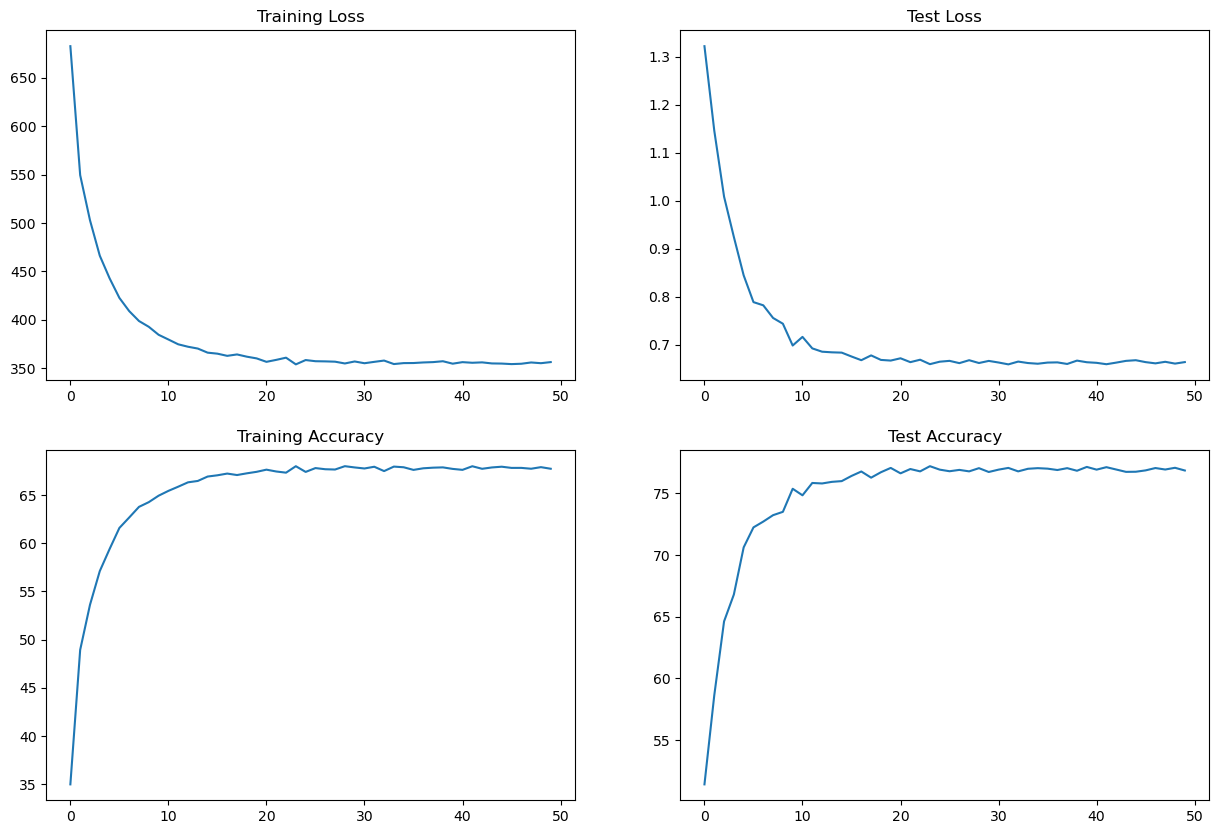

In [25]:
plot_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified dataset

In [26]:
model.eval()

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): 
        incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
        incorrect_labels.append(target[idxs_mask].cpu().numpy())
        incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy())

In [27]:
print(incorrect_labels[0])
print(incorrect_pred[0])

[5 3 5 8 7 5 7 5 8 2 7 2 3 4 2 0 6 3 2 0 7 8 7 2 2 7 5 2]
[3 1 2 2 9 7 6 4 0 0 6 3 6 6 0 8 3 6 4 4 5 3 4 5 0 2 6 6]


In [28]:
print(incorrect_examples[0][0])

[[[-1.4496626  -0.8304676   0.02687943 ... -0.94160515 -0.90985155
   -0.6240692 ]
  [-1.1003731  -0.37004048  0.23327778 ... -0.97335875 -0.8304676
   -0.560562  ]
  [-0.9892355  -0.6558228  -0.37004048 ... -0.90985155 -0.8304676
   -0.7034532 ]
  ...
  [ 0.7095817   0.8683496   0.88422644 ...  0.9001032   0.88422644
    0.8683496 ]
  [ 0.6301977   0.78896564  0.8683496  ...  0.995364    0.88422644
    0.78896564]
  [ 0.5349369   0.69370484  0.8048424  ...  1.0429944   0.9794872
    0.82071924]]

 [[-1.8391187  -1.4679415  -0.79013956 ... -1.2420075  -1.2097312
   -0.9192447 ]
  [-1.5486323  -1.0644879  -0.61262    ... -1.2581457  -1.1129024
   -0.8546921 ]
  [-1.3226982  -1.2581457  -1.1290405  ... -1.1935931  -1.1290405
   -1.0322117 ]
  ...
  [ 0.46863553  0.6461551   0.6945695  ...  0.6138788   0.5816025
    0.59774065]
  [ 0.38794482  0.5816025   0.6945695  ...  0.7591221   0.6300169
    0.5331881 ]
  [ 0.27497783  0.46863553  0.6300169  ...  0.8398128   0.7752602
    0.6138788 ]

## Sample Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

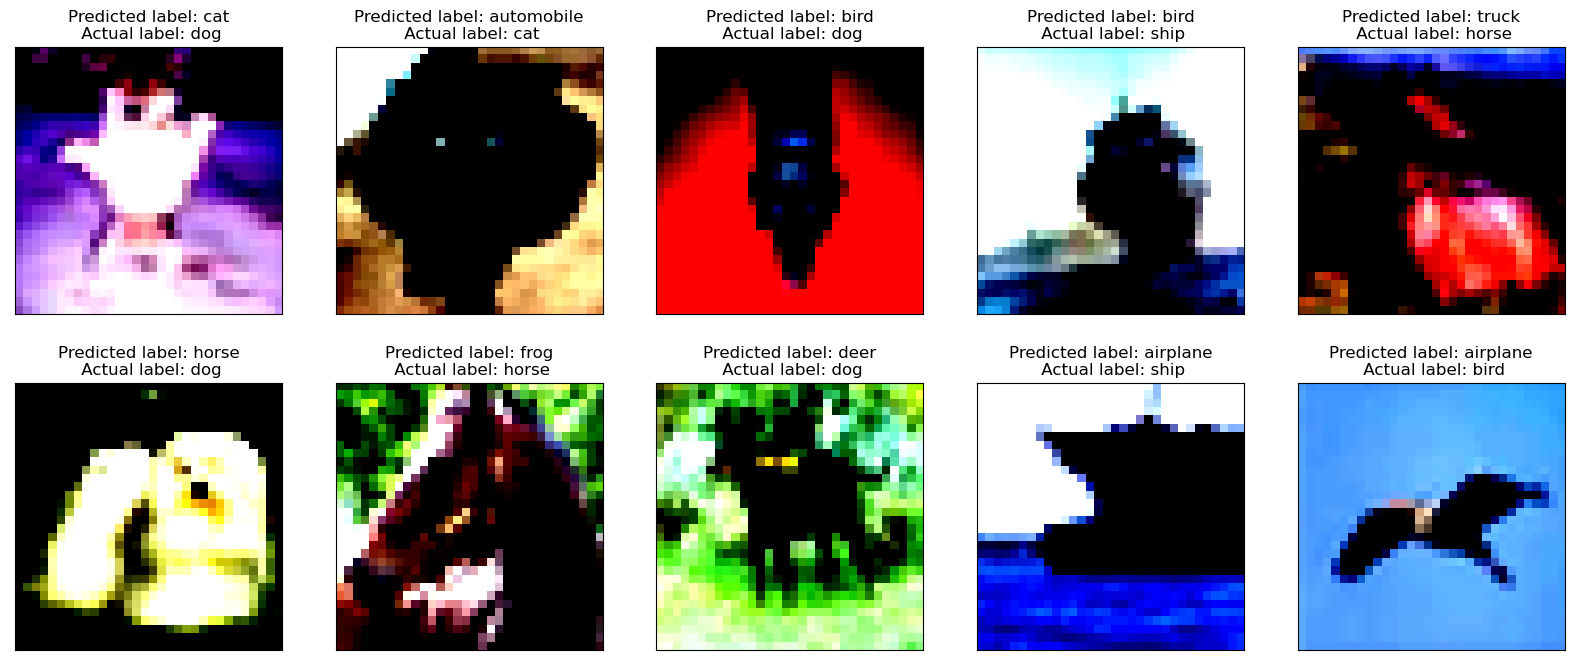

In [29]:
import numpy as np
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = incorrect_examples[0][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(incorrect_examples[0][idx], (1, 2, 0)))
    ax.set_title(f"Predicted label: {classes[incorrect_pred[0][idx]]}\n Actual label: {classes[incorrect_labels[0][idx]]}")
    